In [1]:
# import modules
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Point
import shapely
import osmnx as ox
import pandas as pd
import networkx as nx
from shapely.geometry import LineString
from tabulate import tabulate


In [2]:
# Reading csv files into panda DataFrames
dfNodes = pd.read_csv("/Users/suvihanninen/Desktop/Research_project/coolwalk/data/CoolWalksDataStorge/nodes.csv")
dfEdges = pd.read_csv("/Users/suvihanninen/Desktop/Research_project/coolwalk/data/CoolWalksDataStorge/edges.csv")
dfShadeEdge = pd.read_csv("/mnt/c/users/kriso/documents/itu/5th_semester/research_project/coolwalk/data/CoolWalksDataStorge/edges.csv")

In [48]:
print(tabulate(dfNodes, headers='keys', tablefmt='psql'))

+-------+-------------+---------+-------------------------------+-------------+-------+-----------+----------+
|       |      osm_id |     lat | geopoint                      |   vertex_id | end   |       lon |   helper |
|-------+-------------+---------+-------------------------------+-------------+-------+-----------+----------|
|     0 |  6518737648 | 53.0406 | POINT (-1.0771582 53.0405631) |           1 | False | -1.07716  |      nan |
|     1 |  2988187805 | 52.9308 | POINT (-1.1072849 52.9308475) |           2 | False | -1.10728  |      nan |
|     2 |   455964115 | 52.9641 | POINT (-1.2230846 52.9640918) |           3 | True  | -1.22308  |      nan |
|     3 |   469811116 | 53.0108 | POINT (-1.1282842 53.010786)  |           4 | True  | -1.12828  |      nan |
|     4 |   322853240 | 52.9092 | POINT (-1.1900777 52.9092031) |           5 | False | -1.19008  |      nan |
|     5 |   462811445 | 52.8942 | POINT (-1.1500034 52.8941629) |           6 | False | -1.15     |      nan |
|

In [3]:
# Transforming relevant columns of DataFrames into GeoSeries to be used as geometry column of GeoDataFrames
dfNodes['geopoint'] = gpd.GeoSeries.from_wkt(dfNodes['geopoint'])
dfEdges['edgegeom'] = gpd.GeoSeries.from_wkt(dfEdges['edgegeom'])
dfShadeEdge['shadowgeom'] = gpd.GeoSeries.from_wkt(dfShadeEdge['shadowgeom'])


In [4]:
# Defining GeoDataFrames with GeoSeries columns from above
gdfNodes = gpd.GeoDataFrame(dfNodes, geometry='geopoint', crs="EPSG:27700")
gdfEdges = gpd.GeoDataFrame(dfEdges, geometry='edgegeom', crs="EPSG:27700")
gdfEdgesShadow = gpd.GeoDataFrame(dfShadeEdge, geometry='shadowgeom', crs="EPSG:27700")


In [41]:
#setting osmid as index for nodes (mutating the dataframe)
gdfNodes.set_index('osm_id', inplace=True) 


#Printing dataframes in readable format
print(tabulate(gdfNodes, headers='keys', tablefmt='psql'))


In [ ]:
#setting src_id, dst_id and osm_id of edge geodf´s as the multiindex(u, v, key) of each node (mutating the dataframe)
gdfEdges.set_index(['src_id','dst_id','osm_id'], inplace=True) #should we use the osm_id from the Nodes instead, since Henrik says they have 0 values to indicate multi-edges, which is what the value 'k' is intended for in the documentation of utils_graph.graph_from_gdfs

#Printing dataframes in readable format
print(tabulate(gdfEdges, headers='keys', tablefmt='psql'))

In [17]:
# Data wrangling: Editing/andjustment GeoDataFrames
gdfNodes.rename(columns = {'lat':'x', 'lon':'y'}, inplace = True)
gdfNodes["x"] = gdfNodes["geopoint"].x
gdfNodes["y"] = gdfNodes["geopoint"].y

print(tabulate(gdfNodes, headers='keys', tablefmt='psql'))


In [39]:
G_shaded = ox.utils_graph.graph_from_gdfs(gdfNodes, gdfEdges, graph_attrs=None)


/home/kriso2/anaconda3/envs/geo_env/lib/python3.10/site-packages/osmnx/utils_graph.py:154: UserWarning: discarding the gdf_nodes geometry column, though its values differ from the coordinates in the x and y columns
  warnings.warn(


In [40]:
Graph_map = ox.folium.plot_graph_folium(G_shaded)

KeyError: 1

In [23]:
def linestring_to_points(feature,geometry):
    return {feature:list(gdfEdges.geometry.iloc[0].coords)}

dfEdges['points'] = dfEdges.apply(lambda l: linestring_to_points(l['osm_id'], l['edgegeom']), axis=1)

print(dfEdges['points'])
# ax = world[world.name == 'Nottingham'].plot(
#     color='white', edgecolor='black')

shadowsPlot = gdfEdgesShadow.copy()

0        {40817927.0: [(-1.0771582, 53.0405631), (-1.07...
1        {40817927.0: [(-1.0771582, 53.0405631), (-1.07...
2        {694322277.0: [(-1.0771582, 53.0405631), (-1.0...
3        {891355126.0: [(-1.0771582, 53.0405631), (-1.0...
4        {1055034396.0: [(-1.0771582, 53.0405631), (-1....
                               ...                        
54622    {nan: [(-1.0771582, 53.0405631), (-1.0771582, ...
54623    {26315920.0: [(-1.0771582, 53.0405631), (-1.07...
54624    {nan: [(-1.0771582, 53.0405631), (-1.0771582, ...
54625    {26315920.0: [(-1.0771582, 53.0405631), (-1.07...
54626    {nan: [(-1.0771582, 53.0405631), (-1.0771582, ...
Name: points, Length: 54627, dtype: object


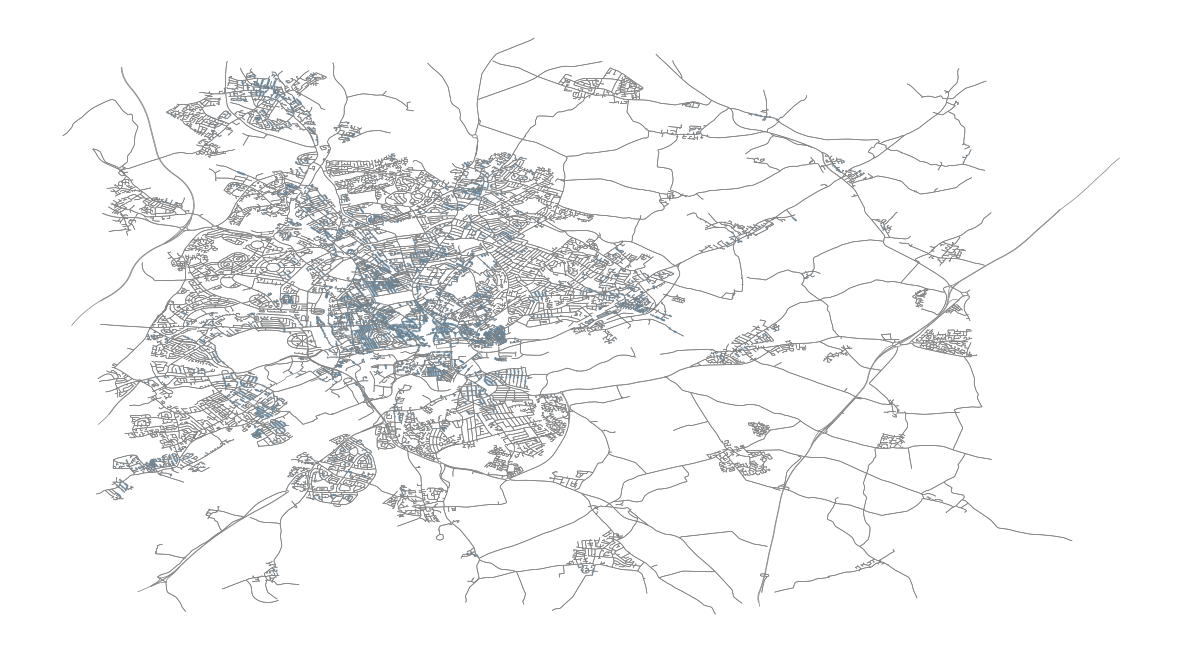

In [24]:
# Medium article ploting
fig, ax = plt.subplots(figsize=(15,15))
shadowsPlot.plot(ax=ax, fc='#b2e8a0', alpha=0.5, zorder=1)
gdfEdges.plot(ax=ax, color='grey', linewidth=0.5)
ax.axis('off')
plt.show()


In [20]:
# Data wrangling: Editing andjustment GeoDataFrames
gdfNodes.rename(columns = {'lat':'x', 'lon':'y'}, inplace = True)
gdfNodes["x"] = gdfNodes["geopoint"].x
gdfNodes["y"] = gdfNodes["geopoint"].y
#ox.utils_graph.graph_from_gdfs(gdfNodes, gdfEdges, graph_attrs=None)
# print(gdfEdgesShadow.head)

In [26]:
# find shadedEdges and shadedNodes
print(gdfEdgesShadow.loc[[1377]])

G_shaded = ox.utils_graph.graph_from_gdfs(gdfNodes, gdfEdgesShadow, graph_attrs=None)


          osm_id  geomlength  src_id  dst_id  \
1377  33825957.0           0     624    4660   

                                               edgegeom  shadowed_length  \
1377  LINESTRING (-1.1127542 52.9595409,-1.1124336 5...              NaN   

      full_length  shadowed_part_length shadowgeom helper  
1377          NaN                   NaN       None    NaN  


/home/kriso2/anaconda3/envs/geo_env/lib/python3.10/site-packages/osmnx/utils_graph.py:154: UserWarning: discarding the gdf_nodes geometry column, though its values differ from the coordinates in the x and y columns
  warnings.warn(


TypeError: cannot unpack non-iterable int object